In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data = pd.read_parquet("/media/michael/Delta/Data/Data_Science_Masters/MSDS_498/recipes_embedded.parquet")
data

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,ingredients_text_embedding_381,ingredients_text_embedding_382,ingredients_text_embedding_383,rating_count_0,rating_count_1,rating_count_2,rating_count_3,rating_count_4,rating_count_5,rating_count_total
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,-0.009026,0.012120,0.082861,0,0,0,0,0,3,3
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,0.064582,0.013286,-0.014859,1,0,0,0,1,2,4
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,...,0.040403,0.032460,0.043497,0,0,0,0,1,0,1
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...",...,0.024248,0.030216,0.069643,0,0,0,0,1,1,2
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,...,0.014114,0.075585,0.041810,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193680,zydeco salad,367912,5,79877,2009-04-25,"['15-minutes-or-less', 'time-to-make', 'prepar...","[14.1, 0.0, 8.0, 0.0, 1.0, 0.0, 1.0]",4,['place the lettuce on a platter or serving di...,"recipe courtesy of b&c seafood, vacherie, la a...",...,-0.022110,-0.015492,-0.004447,0,0,0,0,0,3,3
193681,zydeco sauce,357451,15,461283,2009-02-23,"['15-minutes-or-less', 'time-to-make', 'course...","[239.9, 30.0, 19.0, 22.0, 1.0, 14.0, 5.0]",3,"['to make the sauce , combine the mayonnaise ,...",great sauce for cheeseburgers or dipping fries...,...,0.028330,0.045326,0.015619,0,0,0,0,0,2,2
193682,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,...,0.066024,0.017025,0.062161,0,0,0,0,0,6,6
193683,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...",...,-0.008967,0.043936,-0.006024,0,1,0,0,0,0,1


# Calculate Density Score

Determine how similar every recipe is to every other recipe.

I am doing the following operation recipe by 1,000 recipe batch because it requires too much memory to do in one shot, and this is fast enough for my level of patience.

In [3]:
# set up the embedding matrix so we can calculate the mean cosine similarity with all other 
embedding_matrix = data[[x for x in data.columns if "_embedding_" in x]].to_numpy()
# normalize all embeddings now so we can just use the dot product for cosine similarity
embedding_matrix /= np.linalg.norm(embedding_matrix, axis=1)[:, np.newaxis]

# set up vector that will store mean cosine similarities
density_score = np.zeros(embedding_matrix.shape[0])

for i in tqdm(range(0, embedding_matrix.shape[0], 1000)):
    upper_index = min(i+1000, embedding_matrix.shape[0]-1)
    density_score[i:upper_index] = np.dot(embedding_matrix, embedding_matrix[i:upper_index,].T).T.mean(axis=1)

data['density_score'] = (density_score - density_score.mean()) / density_score.std()
data['density_score'] = np.clip(data['density_score'], *np.quantile(data['density_score'], [0.001, 0.999]))
data['density_score'] 

100%|██████████| 194/194 [03:16<00:00,  1.01s/it]


0         0.299902
1        -0.996366
2        -0.344508
3         0.157254
4        -0.421429
            ...   
193680   -0.795401
193681    0.012032
193682    0.845002
193683   -1.021986
193684   -4.636743
Name: density_score, Length: 193685, dtype: float64

(array([  547.,  1061.,  2323.,  5347., 12241., 28589., 52359., 57556.,
        28416.,  5246.]),
 array([-4.63674313, -3.9469919 , -3.25724068, -2.56748945, -1.87773822,
        -1.187987  , -0.49823577,  0.19151545,  0.88126668,  1.57101791,
         2.26076913]),
 <BarContainer object of 10 artists>)

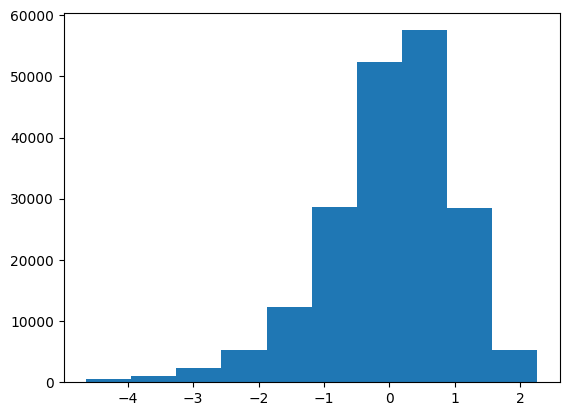

In [4]:
plt.hist(data['density_score'] )

# Recipe Quality Score

Create a score for how good a recipe is expected to be.

In [5]:
data

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,ingredients_text_embedding_382,ingredients_text_embedding_383,rating_count_0,rating_count_1,rating_count_2,rating_count_3,rating_count_4,rating_count_5,rating_count_total,density_score
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,0.012120,0.082861,0,0,0,0,0,3,3,0.299902
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,0.013286,-0.014859,1,0,0,0,1,2,4,-0.996366
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,...,0.032460,0.043497,0,0,0,0,1,0,1,-0.344508
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...",...,0.030216,0.069643,0,0,0,0,1,1,2,0.157254
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,...,0.075585,0.041810,0,0,0,0,0,1,1,-0.421429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193680,zydeco salad,367912,5,79877,2009-04-25,"['15-minutes-or-less', 'time-to-make', 'prepar...","[14.1, 0.0, 8.0, 0.0, 1.0, 0.0, 1.0]",4,['place the lettuce on a platter or serving di...,"recipe courtesy of b&c seafood, vacherie, la a...",...,-0.015492,-0.004447,0,0,0,0,0,3,3,-0.795401
193681,zydeco sauce,357451,15,461283,2009-02-23,"['15-minutes-or-less', 'time-to-make', 'course...","[239.9, 30.0, 19.0, 22.0, 1.0, 14.0, 5.0]",3,"['to make the sauce , combine the mayonnaise ,...",great sauce for cheeseburgers or dipping fries...,...,0.045326,0.015619,0,0,0,0,0,2,2,0.012032
193682,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,...,0.017025,0.062161,0,0,0,0,0,6,6,0.845002
193683,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...",...,0.043936,-0.006024,0,1,0,0,0,0,1,-1.021986


In [6]:
quality_index = ((data['rating_count_5'] * 2 + data['rating_count_4']) / data['rating_count_total']) * np.sqrt(np.minimum(data['rating_count_total'], 10) / 10) / 2
data['quality_index'] = quality_index
quality_index

0         0.547723
1         0.395285
2         0.158114
3         0.335410
4         0.316228
            ...   
193680    0.547723
193681    0.447214
193682    0.774597
193683    0.000000
193684    0.182574
Length: 193685, dtype: float64

(array([11747., 22181., 10968., 63473., 28522., 16923., 11247., 13030.,
         9802.,  5792.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

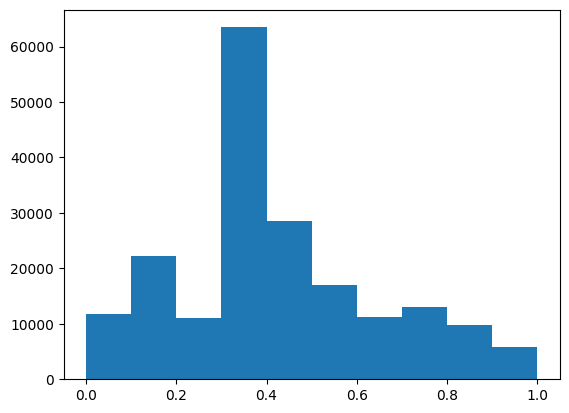

In [7]:
plt.hist(quality_index)

# Create Combined Recipe Sample Weight and Create the Output Sample Files

In [12]:
data[["id", 'density_score', 'quality_index']].to_parquet(f"/media/michael/Delta/Data/Data_Science_Masters/MSDS_498/recipe_quality_and_density_scores.parquet")

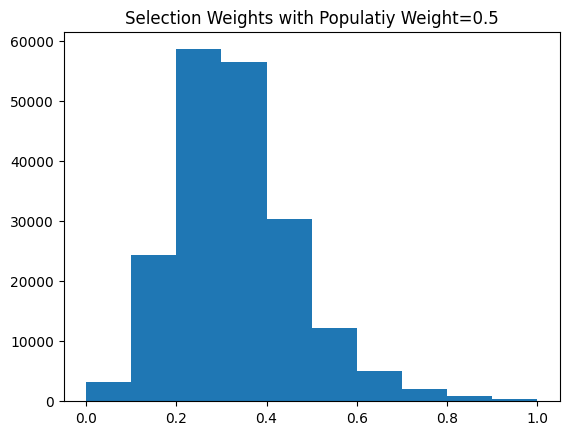

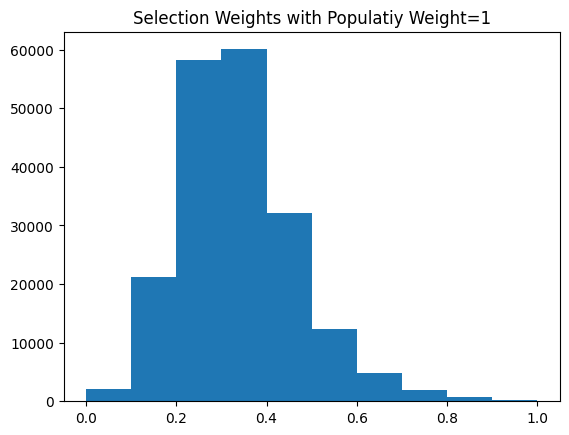

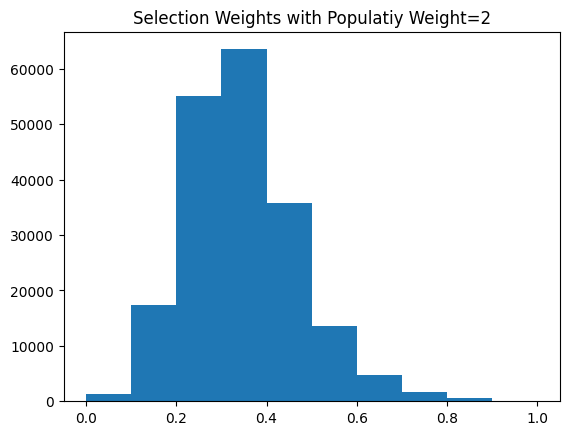

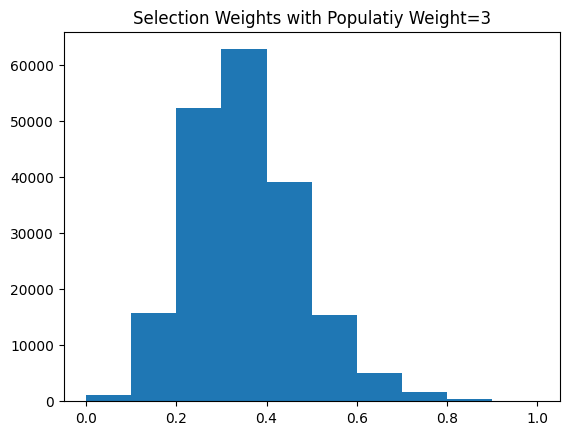

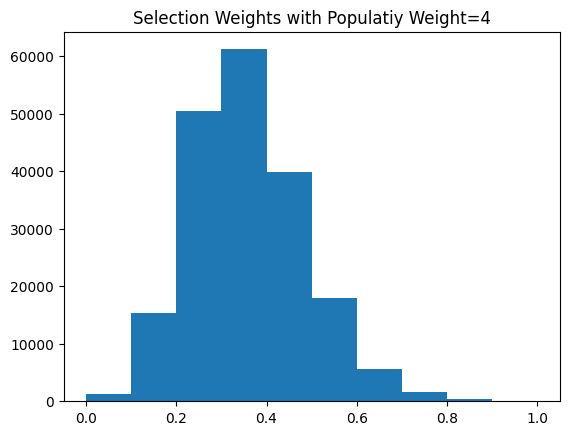

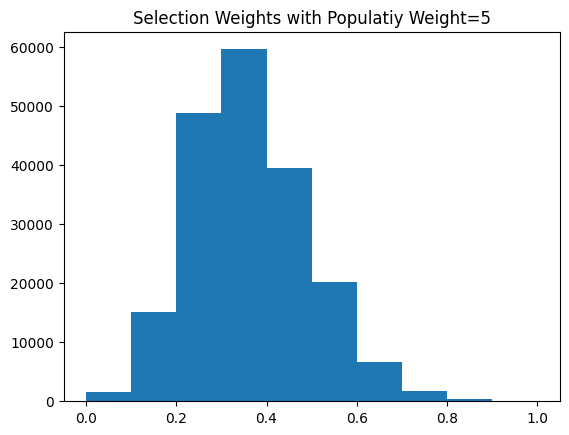

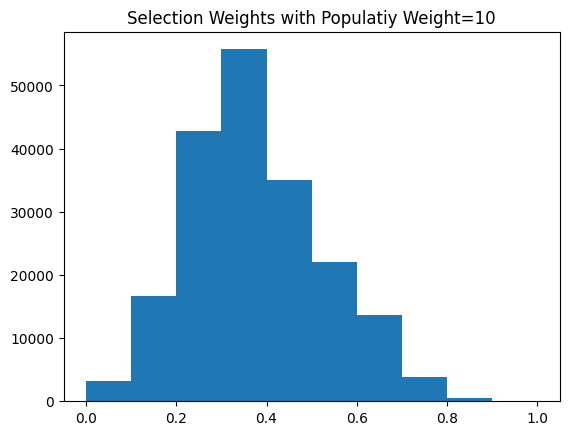

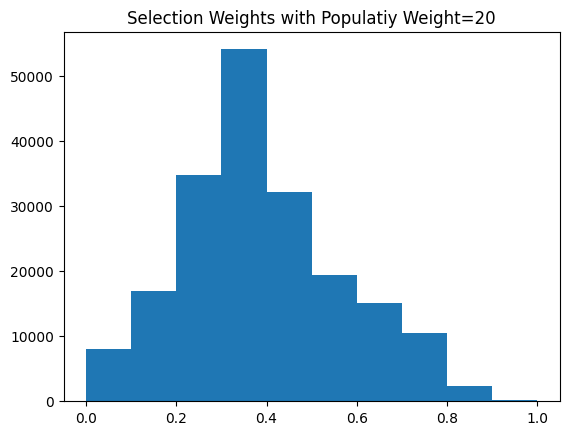

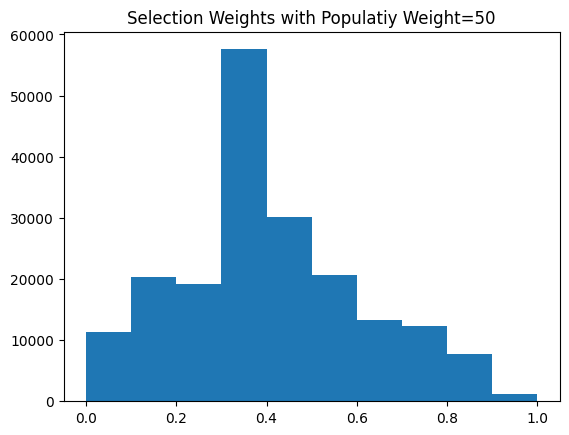

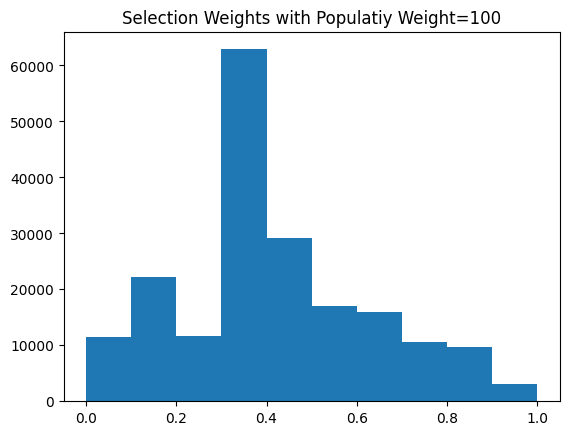

,id,density_score,quality_index,selection_weight,selection_probability
1,31490,-0.996366,0.395285,0.400249,0.000005
2,112140,-0.344508,0.158114,0.172283,0.000002
6,67888,0.135377,0.316228,0.315706,0.000004
8,42198,-0.799106,0.494975,0.491661,0.000006
9,67547,1.370803,0.600000,0.569611,0.000007
...,...,...,...,...,...
193674,424875,-0.704133,0.158114,0.175648,0.000002
193676,103312,1.328460,0.418330,0.400059,0.000005
193678,61748,0.606356,0.547723,0.527858,0.000007
193681,357451,0.012032,0.447214,0.439394,0.000006


In [24]:
np.random.seed(498)

for popularity_weight in [0.5, 1, 2, 3, 4, 5, 10, 20, 50, 100]:

    data['selection_weight'] = popularity_weight * data['quality_index'] - data['density_score'] 
    data['selection_weight'] = (data['selection_weight'] - data['selection_weight'].min()) / (data['selection_weight'].max() -  data['selection_weight'].min())
    data['selection_probability'] = data['selection_weight'] / data['selection_weight'].sum()
    plt.hist(data['selection_weight'])
    plt.title(f"Selection Weights with Populatiy Weight={popularity_weight}")
    plt.show()

    for sample_size in [1000, 2000, 3000, 4000, 5_000, 10_000, 25_000, 50_000, 100_000]:

        random_sample_index = np.random.choice(
            data.index, 
            sample_size,
            replace=False,
            p=data["selection_probability"]
        )

        selected_data = data[data.index.isin(random_sample_index)][['id', 'density_score', 'quality_index', 'selection_weight', 'selection_probability']]
        selected_data.to_parquet(f"/media/michael/Delta/Data/Data_Science_Masters/MSDS_498/recipe_samples/recipes_sample_n={sample_size}_weight={popularity_weight}.parquet")
 
selected_data